## This Notebook will aim to Optimize linear Models

I have a lot of different automatic results in the previous notebook so just manually take most optimal features and reduce from there



## Start with Naive Bayes


'avg3Months_Loan', 'avg3Months_DebtCollection', 'avg6Months_Loan', 'avg6Months_Gambling', 'avg_Gambling', 'avg_Salary', 'avg3Months_Deposit', 'avg3Months_Gambling','avg_Loan', 'avg_HousingCost', 'avg3Months_CashWithdrawal' ,'avg6Months_DirectDebit', 'avg_Gaming', 'avg3Months_Gaming', 'avg_CashWithdrawal', 'avg_OtherIncome', 'avg6Months_CashWithdrawal', 'avg6Months_InstallmentPayment', 'avg_DirectDebit', 'avg6Months_HousingCost', 'avg6Months_Gaming', 'avg3Months_DirectDebit'
'count_Loan', 'trend_DebtCollection', 'sum_Loan', 'trend_Deposit', 'sum_Gambling', 'count_Gambling', 'sum_Salary', 'trend_CashWithdrawal', 'sum_DirectDebit',

'sum installmentPayments', 'trend_Loan', 'Gambling_sum9Months', 'MoneyRemittance_monthlyAvg','trend_Salary', 'MoneyRemittance_partOfSalary9Months', 'Gambling_sum12Months', 'trend_MoneyRemittance', 'Crypto_count3Months', 'trend_OtherIncome', 'trend_PassiveIncome', 'Gambling_count9Months', 'Gambling_partOfSalary3Months', 'MoneyRemittance_category',

'DebtCollection_count9Months', 'CashWithdrawal_sum3Months'

'DebtCollection_sum3Months', 'DebtCollection_sum9Months', 'InstallmentPayment_count12Months', 'DebtCollection_partOfSalary12Months', 'DebtCollection_sum12Months', 'InstallmentPayment_count9Months',



In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200




################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')

df = pd.concat([train,val,test])

In [ ]:
# df= df.iloc[:,:200]

In [2]:

# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')


In [6]:


preprocessor = DataPreprocessor(df)

all_features = df.drop(columns=['Ever90','ReceivedDate',	'ApplicationID','AccountNumber','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','HasCoapp','NR']).columns ## DROP THESE SINCE THEY ARE JUST IDENTIFIERS   --'_merge',

input = df[['Ever90'] +list(all_features) ]

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)

input_dim = Xtrain.shape[1]

In [3]:
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import torch
from torch import nn
from torch.optim import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Custom Torch Classifier
class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, lr=0.001, weight_decay=0.0005, dropout_rate=0.6, num_epochs=5):
        self.input_dim = input_dim
        self.lr = lr
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.num_epochs = num_epochs
        self.model = self._build_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        return model

    def fit(self, X, y):
        self.model.train()
        criterion = nn.BCELoss()
        optimizer = Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        for epoch in range(self.num_epochs):
            for data in loader:
                inputs, labels = data
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
        return outputs.numpy()

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba > 0.5).astype(int)

# Custom gini scorer
def gini_scorer(y_true, y_pred_proba):
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_true, y_pred_proba)
    return 2 * auc - 1

# Plot ROC curve with Gini Coefficient
def plot_gini(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)
    y_val_pred_proba = model.predict_proba(X_val)
    y_test_pred_proba = model.predict_proba(X_test)

    fpr_train, tpr_train, _ = roc_curve(Y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(Y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(Y_test, y_test_pred_proba)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_val = auc(fpr_val, tpr_val)
    roc_auc_test = auc(fpr_test, tpr_test)

    gini_train = 2 * roc_auc_train - 1
    gini_val = 2 * roc_auc_val - 1
    gini_test = 2 * roc_auc_test - 1

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {roc_auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {roc_auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {roc_auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

    

Best hyperparameters: {'dropout_rate': 0.01, 'lr': 0.001, 'num_epochs': 4, 'weight_decay': 0.0005}


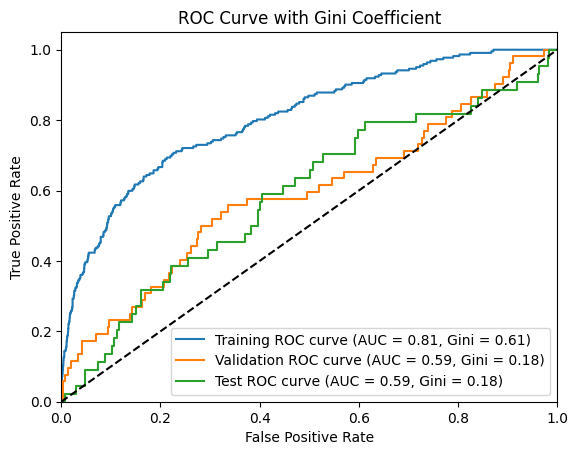

In [ ]:

# Hyperparameter tuning
# param_grid = {
#     'lr': [0.001 , 0.03 , 0.0001 , 0.0005, 0.00001],
#     'weight_decay': [0.0005 ,0.05],
#     'dropout_rate': [0.4,0.6] ,
#     'num_epochs': [6,14,20]
# }

param_grid = {
    'lr': [0.001 ,0.005,0.0005 ],
    'weight_decay': [0.0005 ,0],
    'dropout_rate': [0.01, 0.2 ,0.4 , 0.45] ,
    'num_epochs': [4,6,7]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=Xtrain.shape[1]),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=Xtrain.shape[1], **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_val_pred_proba = best_model.predict_proba(Xval)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_val = gini_scorer(Yval, y_val_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)


plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


## Reduce dataset based on BRFS of RF as input into DL

In [ ]:
selected = [
    'avg_Gambling', 'avg_HousingCost', 'avg_Loan', 'avg_Salary',
    'avg3Months_CashWithdrawal', 'avg3Months_Deposit', 'avg3Months_Loan',
    'avg3Months_MobilePayment', 'avg3Months_Salary', 'avg6Months_Gambling',
    'avg6Months_Gaming', 'avg6Months_HousingCost', 'avg6Months_Loan',
    'avg6Months_MobilePayment', 'avg6Months_Salary', 'count_Gambling',
    'count_InstallmentPayment', 'count_Loan', 'count_MobilePayment',
    'count_PassiveIncome', 'count_Salary', 'sum_Gaming', 'sum_OtherIncome',
    'sum_Salary', 'trend_DebtCollection', 'trend_Deposit', 'trend_Gaming',
    'trend_MobilePayment', 'trend_Salary', 'Gambling_category',
    'Gambling_count6Months', 'Gambling_monthlyAvg', 'Gambling_sum12Months',
    'CashWithdrawal_count6Months', 'CashWithdrawal_sum12Months',
    'CashWithdrawal_sum6Months', 'Gaming_count3Months', 'Gaming_count9Months',
    'MobilePayment_count12Months', 'MobilePayment_partOfSalary12Months',
    'MobilePayment_partOfSalary6Months', 'DebtCollection_count12Months',
    'DebtCollection_sum12Months', 'DebtCollection_sum3Months',
    'InstallmentPayment_count12Months', 'InstallmentPayment_monthlyAvg',
    'InstallmentPayment_partOfSalary12Months',
    'InstallmentPayment_partOfSalary9Months', 'InstallmentPayment_sum6Months',
    'HousingCost_count12Months', 'HousingCost_count6Months',
    'HousingCost_partOfSalary3Months', 'DirectDebit_count3Months',
    'DirectDebit_sum12Months', 'DirectDebit_sum3Months',
    'Unclassified_sum3Months'
]

       

Best hyperparameters: {'dropout_rate': 0.4, 'lr': 0.001, 'num_epochs': 6, 'weight_decay': 0.0005}


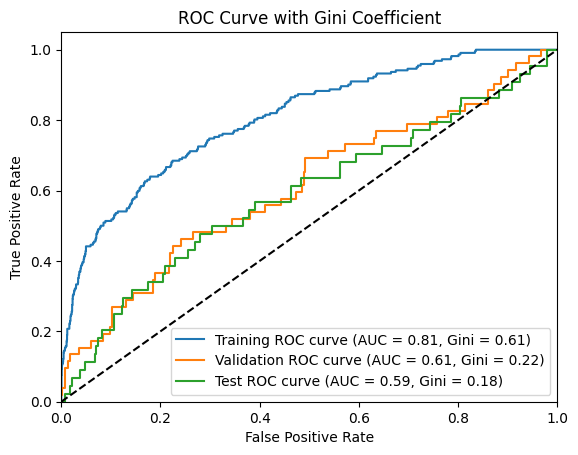

In [ ]:
S_selected = selected #[:40]

input = df[['Ever90'] +list(S_selected) ]

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)

input_dim = Xtrain.shape[1]


# Hyperparameter tuning
param_grid = {
    'lr': [0.001 , 0.03 , 0.0001 , 0.0005, 0.00001],
    'weight_decay': [0.0005 ,0.05],
    'dropout_rate': [0.4,0.9] ,
    'num_epochs': [6,14,20]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=Xtrain.shape[1]),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=Xtrain.shape[1], **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_val_pred_proba = best_model.predict_proba(Xval)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_val = gini_scorer(Yval, y_val_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)


plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.003, 'num_epochs': 25, 'weight_decay': 0.01}


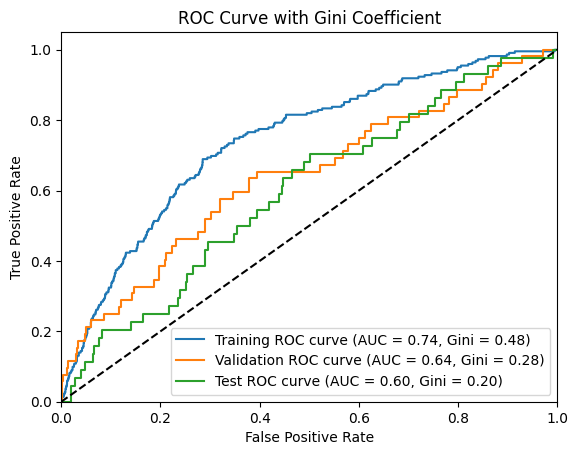

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'lr': [0.001, 0.003, 0.0008, 0.01, 0.005],
    'weight_decay': [0.0005, 0.005, 0.001, 0.01],
    'dropout_rate': [0.2, 0.4, 0.6, 0.5, 0.3],
    'num_epochs': [3, 5, 7, 9, 12, 15, 20, 25]
}


# Initialize variables to store the best model and corresponding validation Gini score
best_model = None
best_gini_val = -np.inf
best_params = None

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    model = TorchClassifier(input_dim=Xtrain.shape[1], **params)
    model.fit(Xtrain, Ytrain)
    
    y_val_pred_proba = model.predict_proba(Xval)
    gini_val = gini_scorer(Yval, y_val_pred_proba)
    
    if gini_val > best_gini_val:
        best_gini_val = gini_val
        best_model = model
        best_params = params

print("Best hyperparameters:", best_params)

# Evaluate best model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)




plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


In [ ]:
# import joblib

# path = "../../2. Python/Finished Models"
# os.chdir(path)

# # Save the model and features
# joblib.dump(best_model, os.path.join( 'MLP_model_1.pkl'))
# np.save(os.path.join( 'optimal_features_MLP_model_1.npy'), optimal_features)
# print("Model and features have been saved to Python/Finished Models.")

In [ ]:
selected = [
    'avg_Gambling', 'avg_HousingCost', 'avg_Loan', 'avg_Salary',
    'avg3Months_CashWithdrawal', 'avg3Months_Deposit', 'avg3Months_Loan',
    'avg3Months_MobilePayment', 'avg3Months_Salary', 'avg6Months_Gambling',
    'avg6Months_Gaming', 'avg6Months_HousingCost', 'avg6Months_Loan',
    'avg6Months_MobilePayment', 'avg6Months_Salary', 'count_Gambling',
    'count_InstallmentPayment', 'count_Loan', 'count_MobilePayment',
    'count_PassiveIncome', 'count_Salary', 'sum_Gaming', 'sum_OtherIncome',
    'sum_Salary', 'trend_DebtCollection', 'trend_Deposit', 'trend_Gaming',
    'trend_MobilePayment', 'trend_Salary', 'Gambling_category',
    'Gambling_count6Months', 'Gambling_monthlyAvg', 'Gambling_sum12Months',
    'CashWithdrawal_count6Months', 'CashWithdrawal_sum12Months',
    'CashWithdrawal_sum6Months', 'Gaming_count3Months', 'Gaming_count9Months',
    'MobilePayment_count12Months', 'MobilePayment_partOfSalary12Months',
    'MobilePayment_partOfSalary6Months', 'DebtCollection_count12Months',
    'DebtCollection_sum12Months', 'DebtCollection_sum3Months',
    'InstallmentPayment_count12Months', 'InstallmentPayment_monthlyAvg',
    'InstallmentPayment_partOfSalary12Months',
    'InstallmentPayment_partOfSalary9Months', 'InstallmentPayment_sum6Months',
    'HousingCost_count12Months', 'HousingCost_count6Months',
    'HousingCost_partOfSalary3Months', 'DirectDebit_count3Months',
    'DirectDebit_sum12Months', 'DirectDebit_sum3Months',
    'Unclassified_sum3Months'
]


len(selected)

56

In [ ]:
S_selected = selected[:36]
len(S_selected)

36

Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.01, 'num_epochs': 3, 'weight_decay': 0.0005}


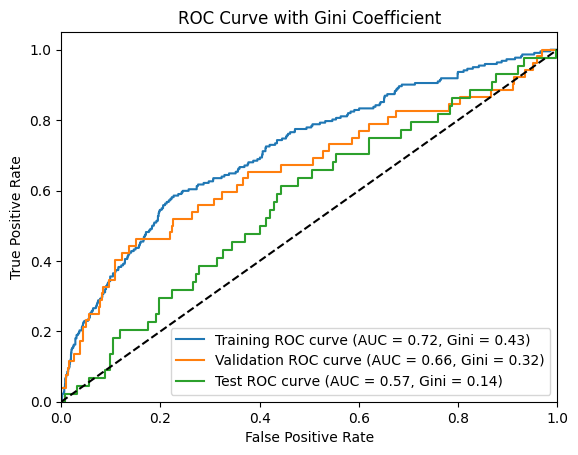

In [ ]:

from sklearn.model_selection import ParameterGrid

param_grid = {
    'lr': [0.001, 0.003, 0.0008, 0.01, 0.005],
    'weight_decay': [0.0005, 0.005, 0.001, 0.01],
    'dropout_rate': [0.2, 0.4, 0.6, 0.5, 0.3],
    'num_epochs': [3, 5, 7, 9, 12, 15, 20, 25]
}


# Initialize variables to store the best model and corresponding validation Gini score
best_model = None
best_gini_val = -np.inf
best_params = None

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    model = TorchClassifier(input_dim=Xtrain.shape[1], **params)
    model.fit(Xtrain, Ytrain)
    
    y_val_pred_proba = model.predict_proba(Xval)
    gini_val = gini_scorer(Yval, y_val_pred_proba)
    
    if gini_val > best_gini_val:
        best_gini_val = gini_val
        best_model = model
        best_params = params

print("Best hyperparameters:", best_params)

# Evaluate best model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)




plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")

       

Best hyperparameters: {'dropout_rate': 0.4, 'lr': 0.01, 'num_epochs': 7, 'weight_decay': 0.001}


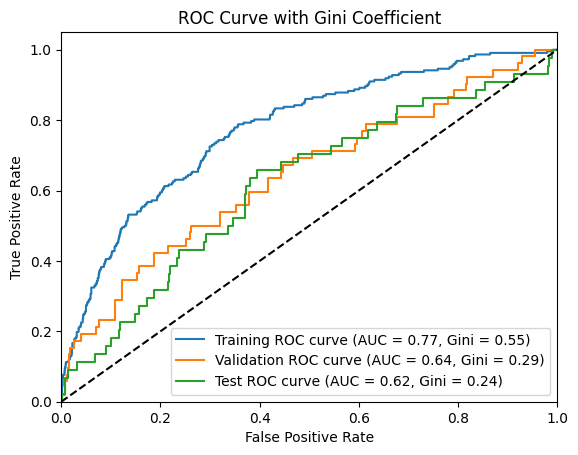

In [ ]:
S_selected = selected[:46]
len(S_selected)


from sklearn.model_selection import ParameterGrid

param_grid = {
    'lr': [0.001, 0.003, 0.0008, 0.01, 0.005],
    'weight_decay': [0.0005, 0.005, 0.001, 0.01],
    'dropout_rate': [0.2, 0.4, 0.6, 0.5, 0.3],
    'num_epochs': [3, 5, 7, 9, 12, 15, 20, 25]
}


# Initialize variables to store the best model and corresponding validation Gini score
best_model = None
best_gini_val = -np.inf
best_params = None

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    model = TorchClassifier(input_dim=Xtrain.shape[1], **params)
    model.fit(Xtrain, Ytrain)
    
    y_val_pred_proba = model.predict_proba(Xval)
    gini_val = gini_scorer(Yval, y_val_pred_proba)
    
    if gini_val > best_gini_val:
        best_gini_val = gini_val
        best_model = model
        best_params = params

print("Best hyperparameters:", best_params)

# Evaluate best model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)




plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")

       

# DOne

Best hyperparameters: {'dropout_rate': 0.2, 'lr': 0.005, 'num_epochs': 7, 'weight_decay': 0.01}


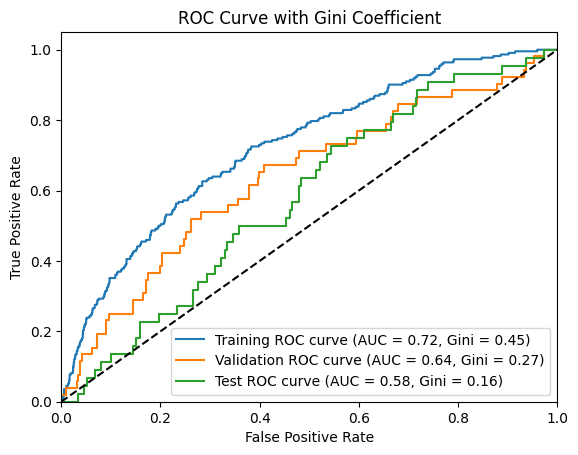

In [ ]:
S_selected = selected[:90]

from sklearn.model_selection import ParameterGrid

# Initialize variables to store the best model and corresponding validation Gini score
best_model = None
best_gini_val = -np.inf
best_params = None

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    model = TorchClassifier(input_dim=Xtrain.shape[1], **params)
    model.fit(Xtrain, Ytrain)
    
    y_val_pred_proba = model.predict_proba(Xval)
    gini_val = gini_scorer(Yval, y_val_pred_proba)
    
    if gini_val > best_gini_val:
        best_gini_val = gini_val
        best_model = model
        best_params = params

print("Best hyperparameters:", best_params)

# Evaluate best model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)




plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


Best hyperparameters: {'dropout_rate': 0.5, 'lr': 0.003, 'num_epochs': 7, 'weight_decay': 0.005}


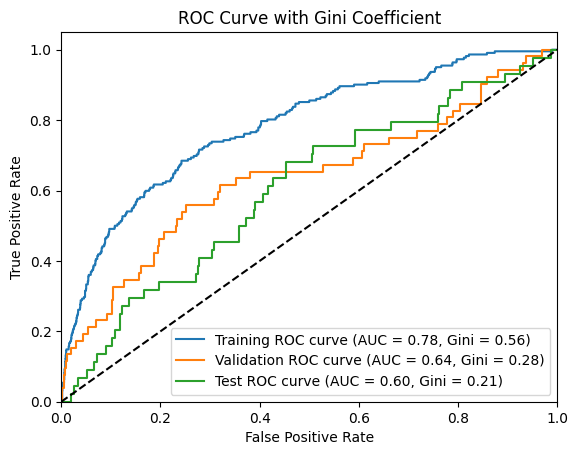

In [ ]:
S_selected = selected[:90]


## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)

input_dim = Xtrain.shape[1]



from sklearn.model_selection import ParameterGrid

# Initialize variables to store the best model and corresponding validation Gini score
best_model = None
best_gini_val = -np.inf
best_params = None

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    model = TorchClassifier(input_dim=Xtrain.shape[1], **params)
    model.fit(Xtrain, Ytrain)
    
    y_val_pred_proba = model.predict_proba(Xval)
    gini_val = gini_scorer(Yval, y_val_pred_proba)
    
    if gini_val > best_gini_val:
        best_gini_val = gini_val
        best_model = model
        best_params = params

print("Best hyperparameters:", best_params)

# Evaluate best model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)




plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


## Färre

In [4]:

selected = ['avg_Loan', 'avg_Salary', 'avg3Months_CashWithdrawal',
       'avg3Months_Deposit', 'avg3Months_Loan', 'avg3Months_Salary',
       'avg6Months_Gambling', 'avg6Months_HousingCost',
       'avg6Months_Salary', 'count_Loan', 'sum_Salary', 'trend_Gaming',
       'trend_MobilePayment', 'Gambling_category', 'Gambling_sum12Months',
       'CashWithdrawal_sum12Months', 'CashWithdrawal_sum6Months',
       'Gaming_count3Months', 'MobilePayment_partOfSalary6Months',
       'DebtCollection_count12Months', 'DebtCollection_sum12Months',
       'InstallmentPayment_count12Months',
       'InstallmentPayment_partOfSalary12Months',
       'HousingCost_count6Months', 'HousingCost_partOfSalary3Months',
       'DirectDebit_sum12Months', 'Unclassified_sum3Months']

Best hyperparameters: {'dropout_rate': 0.2, 'lr': 0.002, 'num_epochs': 3, 'weight_decay': 5e-05}


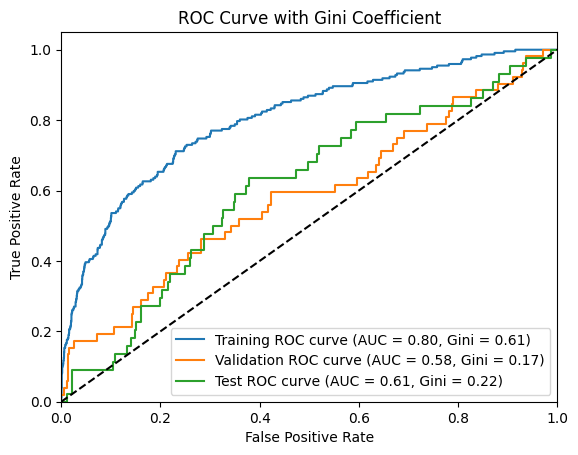

In [22]:
S_selected = selected #[:40]

input = df[['Ever90'] +list(S_selected) ]

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)

input_dim = Xtrain.shape[1]


# Hyperparameter tuning
param_grid = {
    'lr': [0.002 ],  # , 0.03 , 0.0001 , 0.0005, 0.00001
    'weight_decay': [0.00005 ,0.05],
    'dropout_rate': [0.2] ,
    'num_epochs': [3]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=Xtrain.shape[1]),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=Xtrain.shape[1], **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_val_pred_proba = best_model.predict_proba(Xval)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_val = gini_scorer(Yval, y_val_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)


plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.001, 'num_epochs': 13, 'weight_decay': 0.0005}
Training Gini: 0.4828
Test Gini: 0.2429


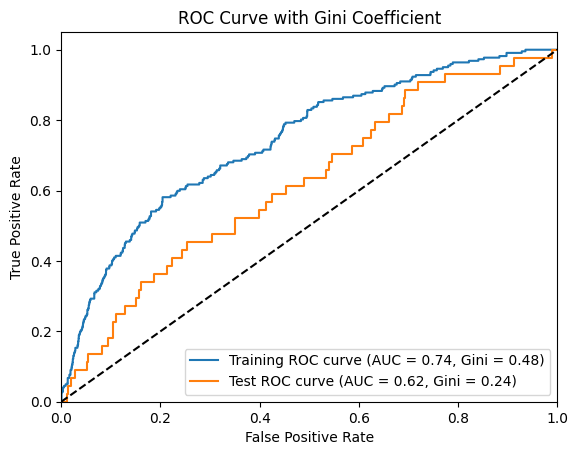

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import torch
from torch import nn
from torch.optim import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Custom classifier wrapper for sklearn
class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, lr=0.001, weight_decay=0.005, dropout_rate=0.5, num_epochs=100):
        self.input_dim = input_dim
        self.lr = lr
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.num_epochs = num_epochs
        self.model = None
    
    def _initialize_model(self):
        model = RegularizedClassifier(self.input_dim, self.dropout_rate)
        optimizer = optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return model, optimizer
    
    def fit(self, X, y):
        train_dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(y).float())
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.model, optimizer = self._initialize_model()
        criterion = nn.BCELoss()
        
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(train_loader.dataset)
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X).float())
        return outputs.numpy().flatten()

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba > 0.5).astype(int)

class RegularizedClassifier(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(RegularizedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 28)
        self.bn2 = nn.BatchNorm1d(28)
        self.fc3 = nn.Linear(28, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x


input_dim = Xtrain.shape[1]

# # Initial test
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.5, 0.7 , 0.8],
#     'num_epochs': [10,20,  50]
# }


# # Hyperparameter tuning
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.4,0.5,0.6, 0.7 , 0.8],
#     'num_epochs': [10, 13,16,25]
# }

# Hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01 ,  0.05],
    'weight_decay': [0.0005, 0.005, 0.05],
    'dropout_rate': [0.6, 0.7 , 0.8],
    'num_epochs': [13,17,25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=input_dim),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=input_dim, **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)

print(f"Training Gini: {gini_train:.4f}")
print(f"Test Gini: {gini_test:.4f}")

def plot_gini(model, X_train, y_train, X_test, y_test, title):
    model.model.eval()
    with torch.no_grad():
        y_train_pred_proba = model.model(torch.tensor(X_train).float()).numpy().flatten()
        y_test_pred_proba = model.model(torch.tensor(X_test).float()).numpy().flatten()

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

plot_gini(best_model, Xtrain, Ytrain, Xtest, Ytest, "ROC Curve with Gini Coefficient")


In [ ]:
S_selected = selected[:90]


## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)

input_dim = Xtrain.shape[1]

Best hyperparameters: {'dropout_rate': 0.6, 'lr': 0.001, 'num_epochs': 13, 'weight_decay': 0.0005}
Training Gini: 0.4964
Test Gini: 0.2346


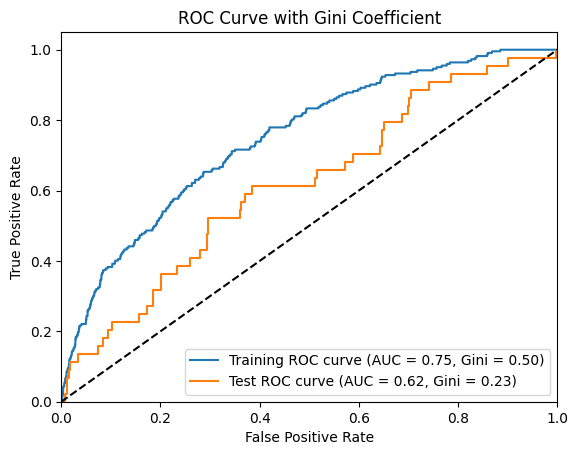

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import torch
from torch import nn
from torch.optim import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Custom classifier wrapper for sklearn
class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, lr=0.001, weight_decay=0.005, dropout_rate=0.5, num_epochs=100):
        self.input_dim = input_dim
        self.lr = lr
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.num_epochs = num_epochs
        self.model = None
    
    def _initialize_model(self):
        model = RegularizedClassifier(self.input_dim, self.dropout_rate)
        optimizer = optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return model, optimizer
    
    def fit(self, X, y):
        train_dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(y).float())
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        self.model, optimizer = self._initialize_model()
        criterion = nn.BCELoss()
        
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(train_loader.dataset)
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X).float())
        return outputs.numpy().flatten()

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba > 0.5).astype(int)

class RegularizedClassifier(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(RegularizedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 28)
        self.bn2 = nn.BatchNorm1d(28)
        self.fc3 = nn.Linear(28, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x


input_dim = Xtrain.shape[1]

# # Initial test
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.5, 0.7 , 0.8],
#     'num_epochs': [10,20,  50]
# }


# # Hyperparameter tuning
# param_grid = {
#     'lr': [0.001, 0.01 ,  0.05],
#     'weight_decay': [0.0005, 0.005, 0.05],
#     'dropout_rate': [0.4,0.5,0.6, 0.7 , 0.8],
#     'num_epochs': [10, 13,16,25]
# }

# Hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01 ,  0.05],
    'weight_decay': [0.0005, 0.005, 0.05],
    'dropout_rate': [0.6, 0.7 , 0.8],
    'num_epochs': [13,17,25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=input_dim),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=input_dim, **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)

print(f"Training Gini: {gini_train:.4f}")
print(f"Test Gini: {gini_test:.4f}")

def plot_gini(model, X_train, y_train, X_test, y_test, title):
    model.model.eval()
    with torch.no_grad():
        y_train_pred_proba = model.model(torch.tensor(X_train).float()).numpy().flatten()
        y_test_pred_proba = model.model(torch.tensor(X_test).float()).numpy().flatten()

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

plot_gini(best_model, Xtrain, Ytrain, Xtest, Ytest, "ROC Curve with Gini Coefficient")
